In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

In [ ]:
# --- 1. DATA FETCHING ---
symbol = input("Enter the stock symbol (e.g., RELIANCE.NS, ^NSEI): ")
print(f"Fetched data for '{symbol}' using yfinance...")

Fetching data for '^NSEI' using yfinance...


##### Fetch Live stock data 

In [5]:
try:
    # Create a Ticker object
    sym_data = yf.Ticker(symbol)

    # Fetch historical market data (1 year of daily data)
    data = sym_data.history(period="6mo", interval="1d")

    if data.empty:
        raise ValueError(
            f"No data found for symbol '{symbol}'. Please check the ticker."
        )

    # Reset index to make 'Date' a column and keep it as datetime objects
    data = data.reset_index()

    # Select and rename columns for clarity
    data = data[["Date", "Open", "High", "Low", "Close"]]
    data["Date"] = pd.to_datetime(data["Date"] , format='%Y-%m-%d')

    print("\nSuccessfully fetched data. Here are the last 5 data points:")
    print(data.tail().round(2))

except Exception as e:
    print(f"\nAn error occurred: {e}")


Successfully fetched data. Here are the last 5 data points:
                         Date      Open      High       Low     Close
118 2025-08-22 00:00:00+05:30  25064.15  25084.85  24859.15  24870.10
119 2025-08-25 00:00:00+05:30  24949.15  25021.55  24894.35  24967.75
120 2025-08-26 00:00:00+05:30  24899.50  24919.65  24689.60  24712.05
121 2025-08-28 00:00:00+05:30  24695.80  24702.65  24481.60  24500.90
122 2025-08-29 00:00:00+05:30  24466.70  24572.45  24404.70  24426.85


##### Neccesary Data pre-processing steps 

In [7]:
# Summary statistics of numerical columns
print("summary statistics  \n",data.describe().T.round(2))

summary statistics  
        count      mean     std       min       25%       50%       75%  \
Open   123.0  24338.50  973.60  21758.40  23843.62  24669.70  25002.17   
High   123.0  24456.24  945.11  22105.05  24018.30  24784.15  25086.77   
Low    123.0  24226.83  971.25  21743.65  23724.62  24539.20  24888.33   
Close  123.0  24347.47  948.37  22082.65  23929.83  24680.90  25002.10   

            max  
Open   25661.65  
High   25669.35  
Low    25523.55  
Close  25637.80  


##### Stock Price Visualization 

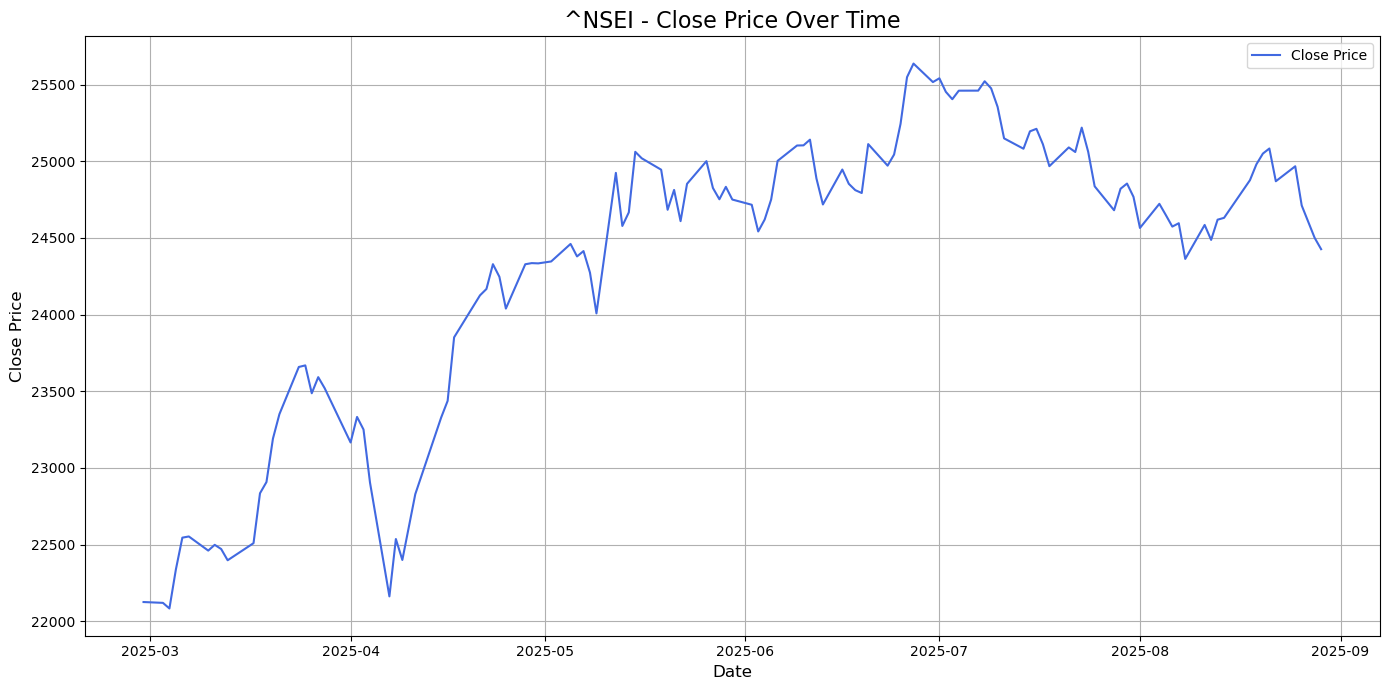

In [8]:
# Plotting the closing price over time
plt.figure(figsize=(14, 7))
plt.plot(data["Date"], data["Close"], label="Close Price", color='royalblue')
plt.title(f"{symbol} - Close Price Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Scatter plot shows the association between two variable (how much they're depended)

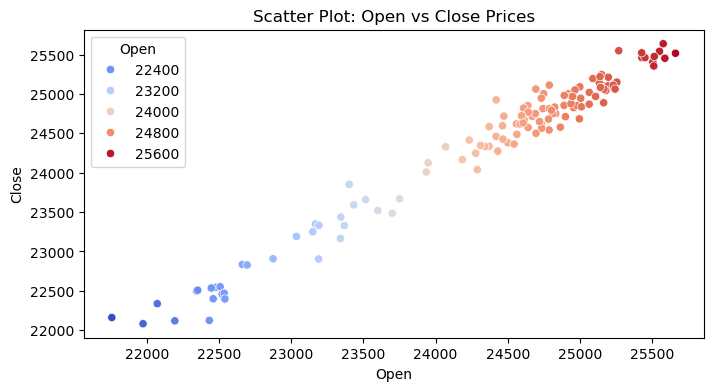

In [12]:
# Scatter plot between Open & Close prices
plt.figure(figsize=(8, 4))
sb.scatterplot(x=data['Open'], y=data['Close'], hue=data['Open'], palette='coolwarm')
plt.title("Scatter Plot: Open vs Close Prices")
plt.show()

##### Heatmap shows the correlations of all the numerical cols and shows how all are connected

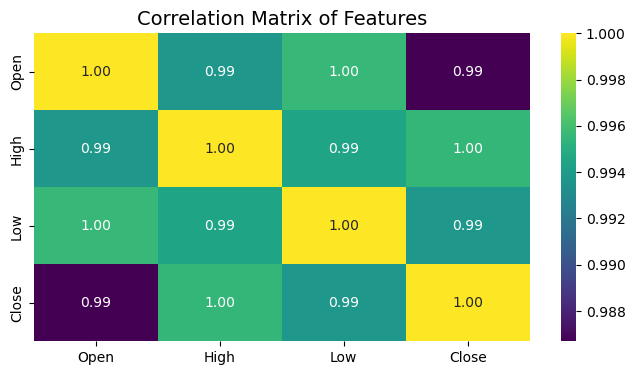

In [11]:
# Heatmap for visualizing correlations
plt.figure(figsize=(8, 4))
numeric_cols = data.select_dtypes(include=np.number)
sb.heatmap(numeric_cols.corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title("Correlation Matrix of Features", fontsize=14)
plt.show()

###### Rule of thumb:-
- 0.5 < skew < 0.5 → fairly symmetrical
- Otherwise → consider transformation

In [13]:
from scipy.stats import skew
print("Skewness (Close):", skew(data['Close']))
print("Skewness (Open):", skew(data['Open']))
print("Skewness (High):", skew(data['High']))
print("Skewness (Low):", skew(data['Low']))

Skewness (Close): -1.008691391033388
Skewness (Open): -1.0022898258882815
Skewness (High): -1.037850859583462
Skewness (Low): -0.9879115436743271


#### Skewness Analysis 
- Market data or live time series data has very uneven skewness which is more common and expected due high volatility and other factors on markets

In [ ]:
# Volume:
# Extremely skewed — a few trading days have unusually high volumes.
# This can cause LSTM to overemphasize rare spikes.
# Solution : Log transformation to reduce skewness.

## As of now, we are not using volume in our model, but if we do, we can apply log transformation to reduce skewness in future. 

In [14]:
## Adding a trend column to the data
# This column indicates whether the price is expected to go up (1) or down (0
data['Trend'] = (data['Close'].shift(-1) > data['Close']).astype(int)

In [15]:
print("Overview of dataset after adding some features \n\n")
data = data.round(2)  # rounding off the values for better readability
print(data.tail())

Overview of dataset after adding some features 


                         Date      Open      High       Low     Close  Trend
118 2025-08-22 00:00:00+05:30  25064.15  25084.85  24859.15  24870.10      1
119 2025-08-25 00:00:00+05:30  24949.15  25021.55  24894.35  24967.75      0
120 2025-08-26 00:00:00+05:30  24899.50  24919.65  24689.60  24712.05      0
121 2025-08-28 00:00:00+05:30  24695.80  24702.65  24481.60  24500.90      0
122 2025-08-29 00:00:00+05:30  24466.70  24572.45  24404.70  24426.85      0


### LSTM MODEL

##### 1️⃣ Preparing Your Data for LSTM
###### LSTMs expect 3D input: [samples, timesteps, features]
where
```
samples = number of training examples
timesteps = how many past days to look back
features = number of columns (Open, High, Low, Close, Volume)
```

Step 1: Apply transformations & scaling

In [16]:
# We will use 'Open', 'High', 'Low', 'Close' as features
features = ["Open", "High", "Low", "Close"]
data_to_scale = data[features]

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_to_scale)

Step 2: Create sequences(timesteps)

In [17]:
# Function to create sequences of data
def create_sequences(dataset, time_steps=60):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        # Sequence of 'time_steps' length
        X.append(dataset[i : (i + time_steps), :])
        # The target is the 'Close' price of the next day
        # 'Close' is the 4th column, so index 3
        y.append(dataset[i + time_steps, 3])
    return np.array(X), np.array(y)


# Define the number of time steps (days) to look back
time_steps = 60
X, y = create_sequences(scaled_data, time_steps)

Step 3: Train-test split (no shuffle)

In [18]:
# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

Training data shape: (50, 60, 4), Training labels shape: (50,)
Testing data shape: (13, 60, 4), Testing labels shape: (13,)


Step 4: LSTM model (Keras - RNN variant) 

In [19]:
# --- 4. BUILD AND TRAIN THE LSTM MODEL ---
model = Sequential()
model.add(
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))
)
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()


print("\nTraining the model...")
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
)
print("Model training complete.")

c:\Devs\anaconda_navigator\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,501 (126.96 KB)

 Trainable params: 32,501 (126.96 KB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 989ms/step - loss: 0.6233 - val_loss: 0.1174
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.1307 - val_loss: 0.0145
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0451 - val_loss: 0.1359
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.1442 - val_loss: 0.0744
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0749 - val_loss: 0.0107
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0242 - val_loss: 0.0092
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0218 - val_loss: 0.0249
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0525 - val_loss: 0.0281
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0595 - val_loss: 0.0190
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0402 - val_loss: 0.0081
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0197 - val_loss: 0.0048
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step 

Model evaluation metrics

In [20]:
# --- 5. EVALUATE THE MODEL ---
# Make predictions on the test set
y_pred_scaled = model.predict(X_test)

# To inverse transform, we need to create an array with the same shape as the original scaled data
# Create a dummy array with n_features columns
n_features = scaled_data.shape[1]
y_pred_unscaled = np.zeros((len(y_pred_scaled), n_features))
y_test_unscaled = np.zeros((len(y_test), n_features))

# Put the predictions and test values into the 'Close' price column (index 3)
y_pred_unscaled[:, 3] = y_pred_scaled.flatten()
y_test_unscaled[:, 3] = y_test.flatten()

# Inverse transform to get the actual prices
y_pred = scaler.inverse_transform(y_pred_unscaled)[:, 3]
y_test_actual = scaler.inverse_transform(y_test_unscaled)[:, 3]


# Calculate performance metrics
rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print("\nModel Evaluation Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2) Score: {r2:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step

Model Evaluation Metrics:
Root Mean Squared Error (RMSE): 247.22
Mean Absolute Error (MAE): 223.54
R-squared (R2) Score: -0.2652


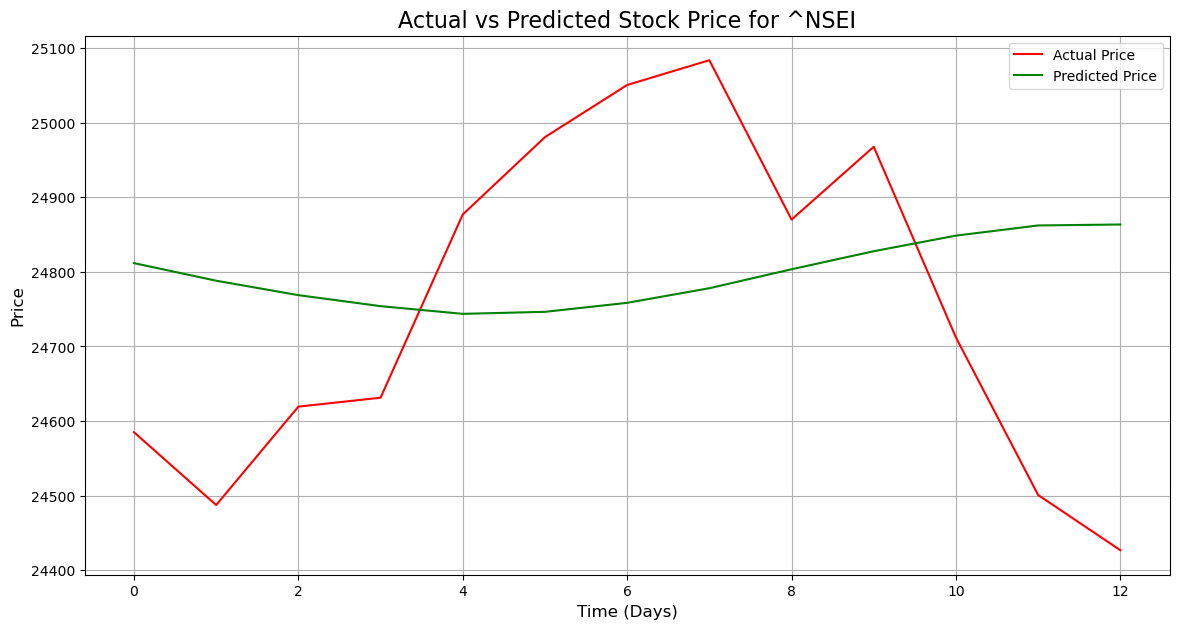

In [ ]:
# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, color='red', label="Actual Price")
plt.plot(y_pred, color='green', label="Predicted Price")
plt.title(f"Actual vs Predicted Stock Price for {symbol}", fontsize=16)
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# --- 6. FORECAST FUTURE PRICES ---
try:
    forecast_days = int(input("\nEnter the number of days to forecast into the future (e.g., 30): "))
    if forecast_days <= 0:
        raise ValueError
except ValueError:
    print("Invalid input. Defaulting to 30 days.")
    forecast_days = 15


Forecasting for the next 10 days...

--- Forecasted Prices ---
                       Date  Predicted Close
0 2025-08-30 00:00:00+05:30         24852.36
1 2025-08-31 00:00:00+05:30         24838.27
2 2025-09-01 00:00:00+05:30         24823.93
3 2025-09-02 00:00:00+05:30         24810.12
4 2025-09-03 00:00:00+05:30         24797.28
5 2025-09-04 00:00:00+05:30         24785.56
6 2025-09-05 00:00:00+05:30         24775.02
7 2025-09-06 00:00:00+05:30         24765.60
8 2025-09-07 00:00:00+05:30         24757.23
9 2025-09-08 00:00:00+05:30         24749.83


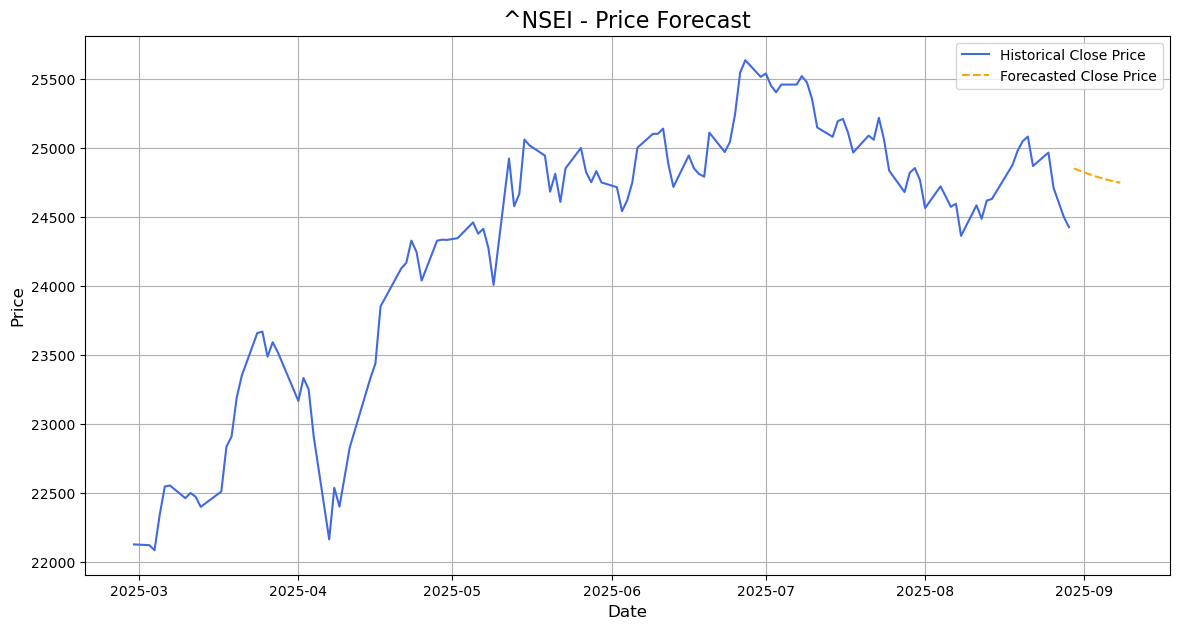

In [23]:
# Use the last 'time_steps' from the original scaled data as the starting point
last_sequence = scaled_data[-time_steps:]
forecast_predictions_scaled = []

current_sequence = last_sequence.reshape(1, time_steps, n_features)

print(f"\nForecasting for the next {forecast_days} days...")

for _ in range(forecast_days):
    # Predict the next day's scaled price
    pred_scaled = model.predict(current_sequence, verbose=0)[0, 0]
    forecast_predictions_scaled.append(pred_scaled)

    # Create a new row for the prediction
    # We use the other features from the last known day
    new_row = current_sequence[0, -1, :].copy()
    new_row[3] = pred_scaled  # Update 'Close' price with the prediction

    # Update the sequence: drop the first day and append the new predicted day
    current_sequence = np.append(current_sequence[:, 1:, :], [[new_row]], axis=1)

# Inverse transform the forecast predictions
forecast_transformed = np.zeros((len(forecast_predictions_scaled), n_features))
forecast_transformed[:, 3] = forecast_predictions_scaled
forecast_prices = scaler.inverse_transform(forecast_transformed)[:, 3]


# Create future dates for the forecast
last_date = data["Date"].iloc[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, forecast_days + 1)]

# Create and display the forecast DataFrame
forecast_df = pd.DataFrame({"Date": future_dates, "Predicted Close": forecast_prices})
print("\n--- Forecasted Prices ---")
print(forecast_df.round(2))

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(data["Date"], data["Close"], label="Historical Close Price", color="royalblue")
plt.plot(
    forecast_df["Date"],
    forecast_df["Predicted Close"],
    label="Forecasted Close Price",
    color="orange",
    linestyle="--",
)
plt.title(f"{symbol} - Price Forecast", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()